In [1]:
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pickle
import pandas as pd

In [2]:
viz_path = 'Visualizations/XGBOOST_EVAL/'

In [3]:
#settings
time_list = [t for t in range(0,5001,120)]
elo_list = ['all','low','medium','high']
time = 5000
playerview = False
fix_keys = ['tf','Elo','player_civ','opp_civ','Feudal Age Time','Castle Age Time','Imperial Age Time']
scenario = '1p_augmented_full_5000_elo_low/'#'1p_augmented_full_5000/'2p_augmented_full_5000_elo_all

data_list = ['full','subsample']
view=2
elo = elo_list[0]
data = data_list[0]

In [4]:

over_cat = []#['Unit Villager','Unit', 'Building Military Production','Technology','Building']#[

#master data
with open(f'masterdata/inv_full_type_dict.pkl', 'rb') as f:
        inv_full_type_dict = pickle.load(f)
with open(f'masterdata/full_type_dict.pkl', 'rb') as f:
        full_type_dict = pickle.load(f)



                    
if playerview:
    #annotate for view:
    views = ['Player ','Opponent ']
    inv_view_type_dict = {}
    view_type_dict = {}
    for view in views:
        for key in inv_full_type_dict:
            try:
                inv_view_type_dict[view + key] = view + inv_full_type_dict[key] 
            except:
                print(view,key)
        for key in full_type_dict:
                view_type_dict[view + key] = []
                for val in full_type_dict[key]:
                    try:
                        view_type_dict[view + key].append(view + val)
                    except:
                        print(view,key,val)
                    
                    
    view_over_cat = []
    
    inv_full_type_dict = inv_view_type_dict
    full_type_dict = view_type_dict

    age_times = fix_keys[-3:]
    fix_keys = fix_keys[:-3]
    
    
    for view in views:
        for age in age_times:
            fix_keys.append(view+age)
        
        for cat in over_cat:
            view_over_cat.append(view+cat)
            
    over_cat = view_over_cat

In [5]:

#load data
#with open(f'data/minn/logs/{scenario}final_log_dict.pkl', 'rb') as f:
        #log_dict = pickle.load(f)
with open(f'data/minn/logs/{view}P_global_log_dict_{data}.pkl', 'rb') as f:
        log_dict = pickle.load(f)[elo]


In [6]:
score_types = ['gain','total_gain']#['f_scores','weight','gain','cover','total_gain','total_cover']

In [7]:

        
score_type_dict = {}
for score_type in score_types:
    

    #init dicts
    eval_dict = {}
    eval_dict_inv = {}
    cat_score_dict = {}
    sub_cat_score_dict = {}
    score_dict = {}
    used_tfs = []


    for tf in time_list:
        
        

        #read eval value and persistate f_scores
        eval_dict[tf] = {'tf': tf, 
                         'test_error': float(log_dict[tf]['final_value'][7:]),
                         'accuracy': 1-float(log_dict[tf]['final_value'][7:])}
        f_scores = log_dict[tf][score_type].copy()


        score_dict[tf] = {}
        cat_score_dict[tf] = {}
        sub_cat_score_dict[tf] = {}


        #score_dict[tf]['tf'] = tf
        score_dict[tf]['player_civ'] = 0
        score_dict[tf]['opp_civ'] = 0

        civ_player = []
        civ_opp = []
        
        #get civs
        for key in f_scores:
            if 'onehotencoder__player_civ_' in key:
                civ_player.append(key)
            elif 'onehotencoder__opp_civ_' in key:
                civ_opp.append(key)
        
        for key in civ_player:
            score_dict[tf]['player_civ']  += f_scores[key]
            del f_scores[key]

        for key in civ_opp:
            score_dict[tf]['opp_civ'] += f_scores[key]
            del f_scores[key]

        #get ages
        for key in f_scores:
            if key:
                if 'elo' in key:
                    clean_key = 'Elo'
                    
                elif playerview:
                    if'remainder__player' in key:
                        if key[18:] != '':
                            clean_key = 'Player ' + key[18:] 
                        else: continue
                    else: 
                        if key[15:] != '':
                            clean_key = 'Opponent '+ key[15:] 
                        else: continue
                else:
                    if'remainder__player' in key:
                        clean_key = key[18:]
                    else: clean_key = key[15:]
                
                #add to score dict if not empty
                if clean_key != 'None' and clean_key != '':
                    score_dict[tf][clean_key] = f_scores[key]
    
        #categorize
        


        #fill cat score dict
        for key in score_dict[tf]:
            if key in fix_keys:
                sub_cat_score_dict[tf][key] = score_dict[tf][key]
            else:
                #print(key,type(key))
                cat_key = inv_full_type_dict[key]
                
                if cat_key in sub_cat_score_dict[tf]:
                    sub_cat_score_dict[tf][cat_key] += score_dict[tf][key]
                else:
                    try:
                        sub_cat_score_dict[tf][cat_key] = score_dict[tf][key]
                    except: print(key,score_dict[tf][key])

        #fill empty values
        for key in fix_keys: 
            if key not in sub_cat_score_dict[tf]:
                sub_cat_score_dict[tf][key] = 0    

        for key in full_type_dict:
                if key not in sub_cat_score_dict[tf]:
                    sub_cat_score_dict[tf][key]  = 0


        used_tfs.append(tf)
        if tf >= time: 
            break

        #aggregate subcategories
     

        for cat in over_cat:
            cat_score_dict[tf][cat] = 0


        for key in sub_cat_score_dict[tf]:
            is_subcat = False

            for cat in over_cat:
                if cat in key:
                    #print(cat,key)
                    cat_score_dict[tf][cat] += sub_cat_score_dict[tf][key]
                    is_subcat = True
                    break

            if not is_subcat:
                cat_score_dict[tf][key] = sub_cat_score_dict[tf][key]
    
    score_type_dict[score_type] ={}
    score_type_dict[score_type]['cat_score_dict'] = cat_score_dict
    score_type_dict[score_type]['sub_cat_score_dict'] = sub_cat_score_dict


eval_df = pd.DataFrame.from_dict(eval_dict, orient='index')
eval_df['used_accuracy'] = eval_df['accuracy']-0.5
#eval_df_inv = pd.DataFrame.from_dict(eval_dict_inv, orient='index')

In [8]:


for score_type in score_types:

    cat_score_df = pd.DataFrame.from_dict(score_type_dict[score_type]['cat_score_dict'], orient='index')
    sub_cat_score_df = pd.DataFrame.from_dict(score_type_dict[score_type]['sub_cat_score_dict'], orient='index')


    abs_threshold = 5
    rel_threshold = 0.005

    #create rel_df
    rel_cat_score_df = cat_score_df.copy()
    
    all_cols = rel_cat_score_df.columns
    rel_cat_score_df['total'] = rel_cat_score_df.sum(axis = 1)
    rel_cat_score_df = rel_cat_score_df[all_cols].div(rel_cat_score_df.total, axis=0)

    acc_rel_cat_score_df =  rel_cat_score_df[all_cols].mul(eval_df['used_accuracy'],axis=0)
    
    
    #reduce cols rel
    drop_cols = []
    for col in rel_cat_score_df.columns:
        if rel_cat_score_df[col].max() <= rel_threshold:
            drop_cols.append(col)

    rel_cat_score_df.drop(drop_cols,axis=1,inplace=True)        
    acc_rel_cat_score_df.drop(drop_cols,axis=1,inplace=True)
    
    #reduce cols abs
    drop_cols = []

    for col in cat_score_df.columns:
        if cat_score_df[col].max() <= abs_threshold:
            drop_cols.append(col)
            
    cat_score_df.drop(drop_cols,axis=1,inplace=True)
    
    sns.set(rc={'figure.figsize':(14,7)})
    sns.set_style("whitegrid")

    """
    sns.lineplot(data=cat_score_df)
    plt.title(f'{score_type} cat score')
    plt.show()

    
    cat_score_df.plot.area(cmap='tab20')
    plt.title(f'{score_type} cat score')
    plt.show()
    
    rel_cat_score_df.plot()
    plt.title(f'{score_type} rel cat score')
    plt.show()

    rel_cat_score_df.plot.area(cmap='tab20')
    plt.title(f'{score_type} rel cat score')
    plt.show()
    """

    

In [9]:
label_rename_dict = {
    'elo': 'Elo Rating',
    'opp_civ': 'Opponent Civilization',
    'player_civ': 'Player Civilization',
    'Unit Villager': 'Unit Economy',
     'Feudal Age Time': 'Time Feudal Age' ,
 'Castle Age Time': 'Time Castle Age' ,
 'Imperial Age Time': 'Time Imperial Age' 
}
               

In [10]:
tab20 = plt.get_cmap('tab20b')
tab20.colors

((0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.6117647

In [11]:
tab20.colors[12]

(0.5176470588235295, 0.23529411764705882, 0.2235294117647059)

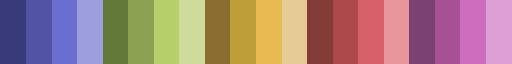

In [12]:
tab20

In [13]:
colors = []
colors.extend([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)])#, #civ blue
               #(0.6823529411764706, 0.7803921568627451, 0.9098039215686274)])
colors.append((0.4980392156862745, 0.4980392156862745, 0.4980392156862745)) #elo grey

colors.extend([ (0.19215686274509805, 0.6392156862745098, 0.32941176470588235), #Eco Green
               (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019)])

colors.extend([(0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), # military red
               (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
               (1.0, 0.596078431372549, 0.5882352941176471),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588)])

colors.extend([(0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451)])


colors.extend([(0.4588235294117647, 0.4196078431372549, 0.6941176470588235),#ages purple
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157)])

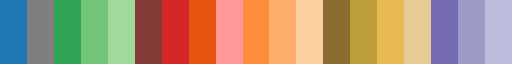

In [14]:
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(colors))
cm 

In [15]:

acc_rel_cat_score_df['Match Up'] = acc_rel_cat_score_df['player_civ'] +acc_rel_cat_score_df['opp_civ'] 

In [16]:
col_order = ['Match Up', 'Elo',
             'Unit Villager', 'Technology Economy','Building Economic',
       'Unit Infantry', 'Unit Foot Archer unit', 'Unit Cavalry',
       'Unit Siege unit', 'Technology Military',
       'Building Military Production', 'Building Research','Building Defensive Structures',
       'Technology Building', 
            'Feudal Age Time', 'Castle Age Time', 'Imperial Age Time',]

In [17]:
acc_rel_cat_score_df = acc_rel_cat_score_df[col_order]

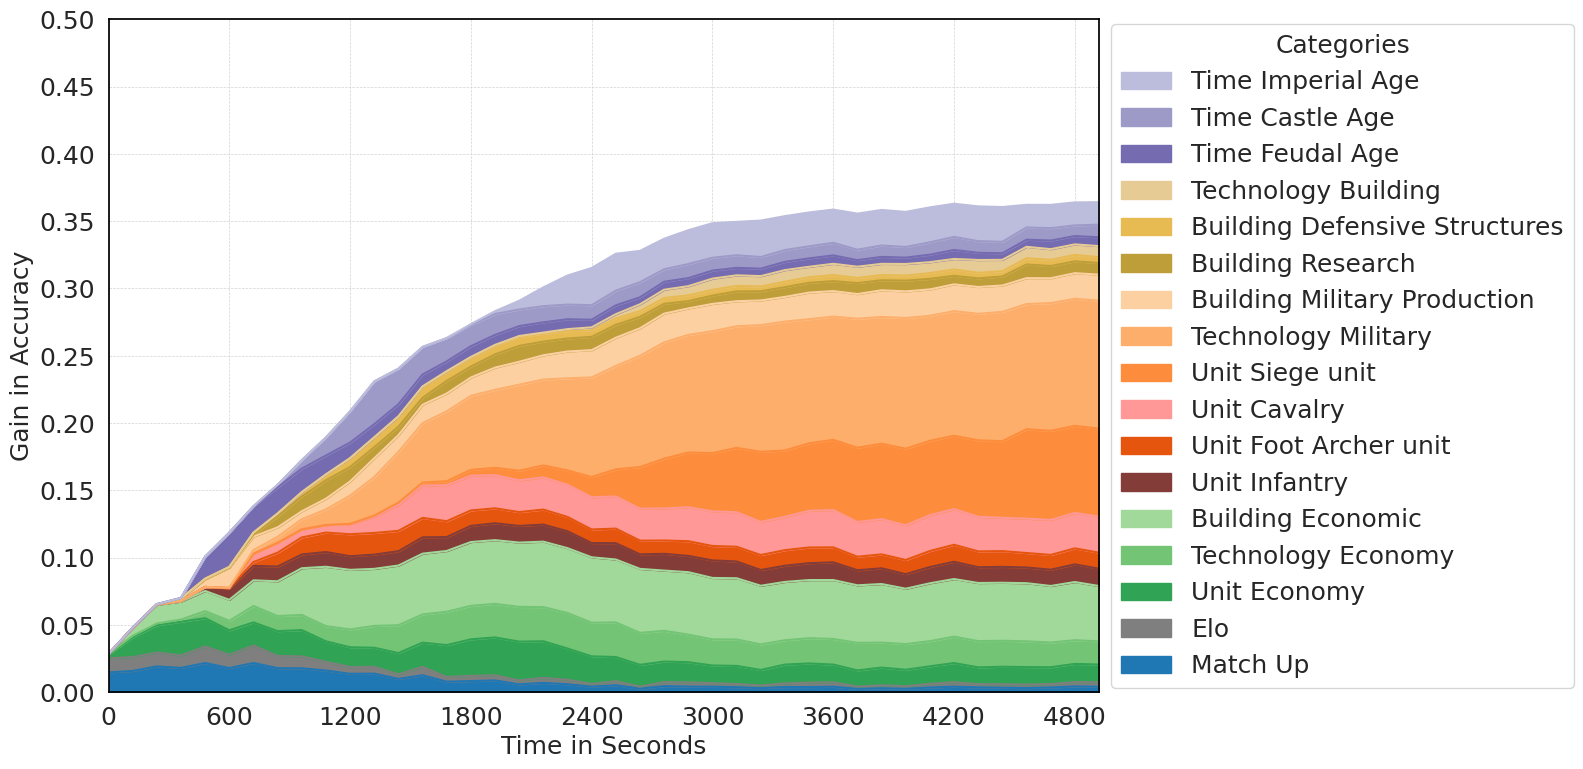

In [18]:
name = f'acc_gain_over_cat_view_{view}_elo_{elo}'

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["axes.edgecolor"]='black'
ax = acc_rel_cat_score_df.plot.area(cmap=cm)

handles, labels = ax.get_legend_handles_labels()

#rename labels
for index,label in enumerate(labels):
    if label in label_rename_dict:
        labels[index] = label_rename_dict[label]


#optics
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5,which='major')
plt.xlabel("Time in Seconds",fontsize=18)
plt.xticks([i for i in range(0,5000,600)],fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Gain in Accuracy",fontsize=18)
plt.yticks([i for i in np.arange(0,0.55,0.05)],fontsize=18)

legend = ax.legend(handles[::-1], labels[::-1], title='Categories',loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18)
plt.setp(legend.get_title(),fontsize='18')

plt.margins(x=0.0)
plt.tight_layout()
plt.savefig(viz_path+name + '.pdf',format='pdf')
plt.show()



In [19]:
#1p/2p ,low elo, high elo 

In [20]:
#https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

In [21]:
rel_cat_score_df.max()

player_civ                       0.260418
opp_civ                          0.258372
Unit Villager                    0.356589
Technology Economy               0.092195
Elo                              0.369787
Feudal Age Time                  0.213110
Castle Age Time                  0.135934
Imperial Age Time                0.086072
Unit Monk                        0.007772
Unit Infantry                    0.077594
Unit Foot Archer unit            0.077876
Unit Cavalry                     0.099630
Unit Siege unit                  0.180367
Unit Gunpowder                   0.010006
Unit Mounted Archer              0.008111
Building Economic                0.231870
Building Research                0.072295
Building Military Production     0.124539
Building Defensive Structures    0.030982
Technology Building              0.025811
Technology Military              0.267042
Technology Age                   0.006086
dtype: float64

In [22]:
for col in rel_cat_score_df.columns:
        if rel_cat_score_df[col].max() <= rel_threshold:
            print(col)

In [23]:
rel_cat_score_df['Match Up'] = rel_cat_score_df['player_civ'] +rel_cat_score_df['opp_civ'] 

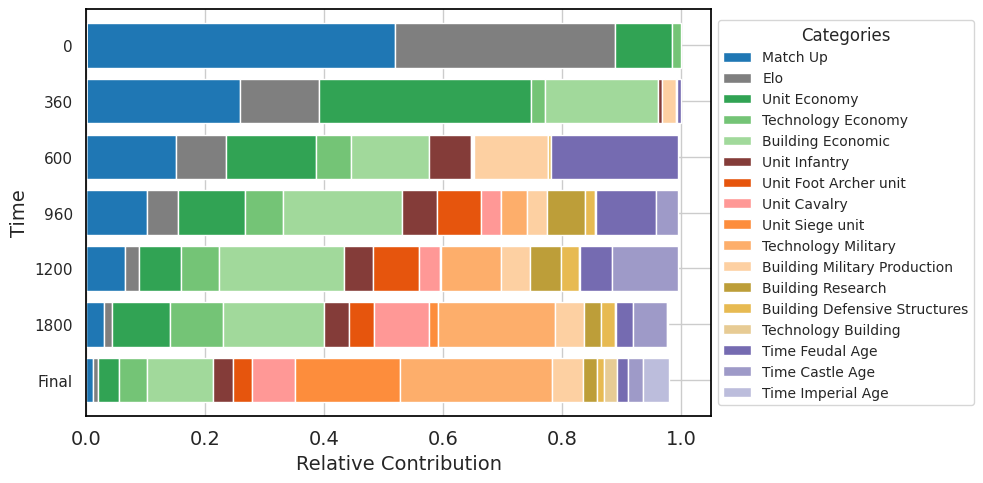

In [24]:
name = f"relative_feature_contribution_view_{view}_elo_{elo}"
#maps_df = maps.to_frame().T



ax = rel_cat_score_df[col_order].loc[[0,360,600,960,1200,1800,4920]].sort_index(ascending=False).plot.barh(stacked=True, figsize=(10,5),cmap=cm,width=0.8)
ax.legend(labels=labels,title='Categories',loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
#ax.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel("Relative Contribution", fontsize=14)
plt.xticks(fontsize=14)

plt.ylabel("Time", fontsize=14)
ax.set_yticklabels(['Final','1800','1200','960','600','360','0'])
plt.tight_layout()
plt.savefig(viz_path+name+ '.pdf',format='pdf')

plt.show()

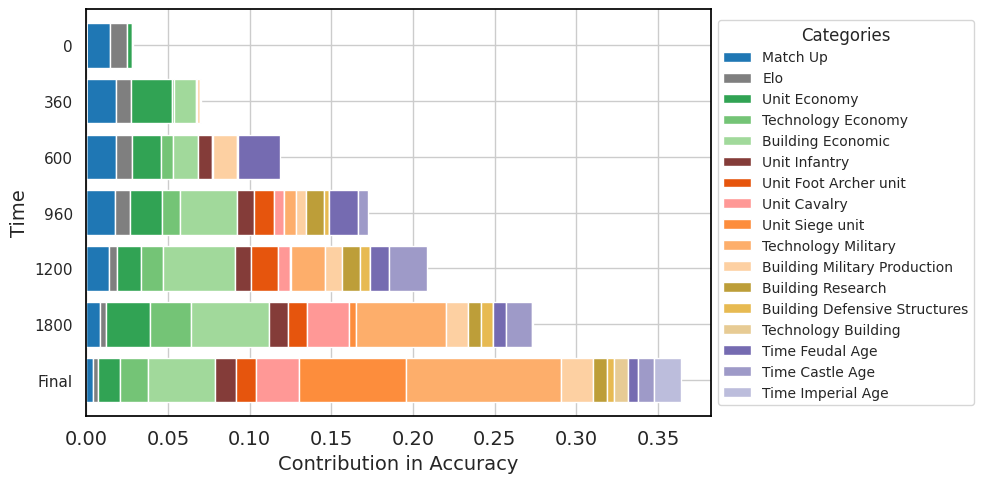

In [25]:
name = f'acc_feature_contribution_view_{view}_elo_{elo}'


ax = acc_rel_cat_score_df[col_order].loc[[0,360,600,960,1200,1800,4920]].sort_index(ascending=False).plot.barh(stacked=True, figsize=(10,5),cmap=cm,width=0.8)
ax.legend(labels=labels,title='Categories',loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
#ax.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel("Contribution in Accuracy", fontsize=14)
plt.xticks(fontsize=14)

plt.ylabel("Time", fontsize=14)
ax.set_yticklabels(['Final','1800','1200','960','600','360','0'])
plt.tight_layout()
plt.savefig(viz_path+name+ '.pdf',format='pdf')
    
plt.show()

In [26]:

with open(f'data/minn/logs/MINN/clean_acc_dict.pkl', 'rb') as f:
        acc_dict_clean = pickle.load(f)
        
acc_dict_clean[1]['all'][4920] = 0.6366439655172415

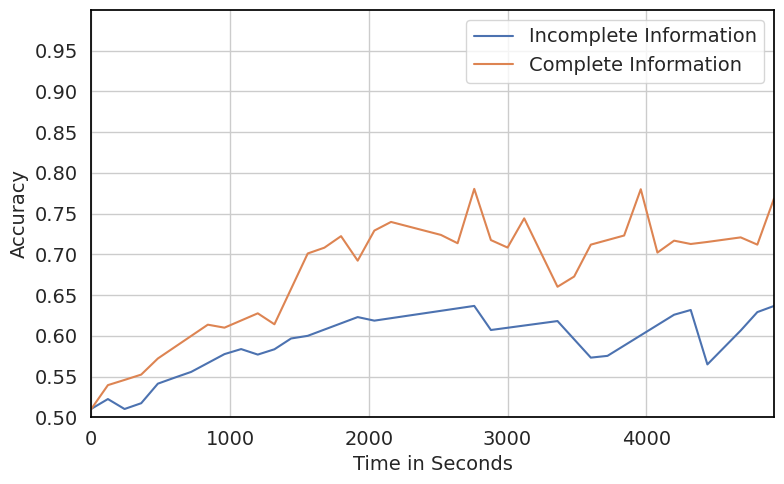

In [31]:
name = 'minn_results'
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.edgecolor"]='black'
labels= ['Incomplete Information','Complete Information']
for view in acc_dict_clean:
    if True:#view==2:
        for elo in acc_dict_clean[view]:
            if elo == 'all':
                sns.lineplot(x=acc_dict_clean[view][elo].keys(),y=acc_dict_clean[view][elo].values())
                #labels.append(f'view:{view} elo: {elo}')
            
plt.legend(labels,fontsize=14)
plt.ylim(0.5,1)
plt.yticks(np.arange(0.5,1,0.05),fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xlabel("Time in Seconds",fontsize=14)
plt.xticks(np.arange(0,5000,1000),fontsize=14)
plt.margins(x=0.0,y=0)
plt.tight_layout()
plt.savefig(viz_path+name + '.pdf',format='pdf')
plt.show()

In [28]:
elo_keys = ['all', 'low', 'medium', 'high']

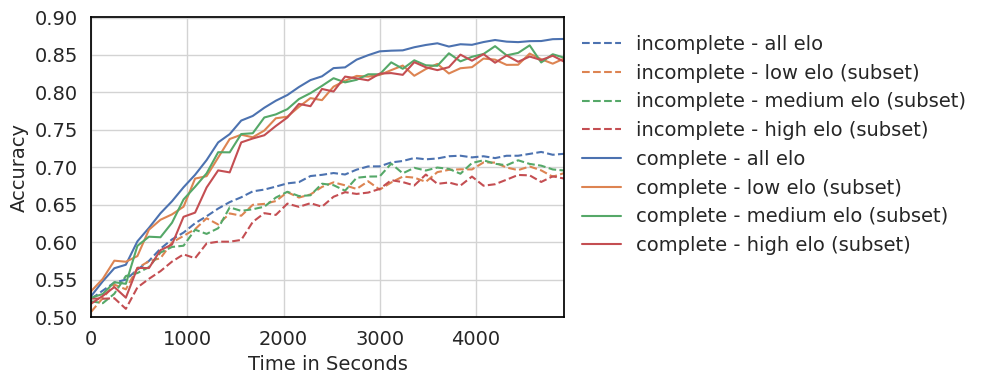

In [29]:
plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["axes.edgecolor"]='black'
name = 'acc_elo'#_all_ss'

dfs = {}

views = [1,2]
view_labels = ['','incomplete','complete']


for view in views:
    
    with open(f'data/minn/logs/{view}P_global_log_dict_full.pkl', 'rb') as f:
            full_global_log_dict = pickle.load(f)
    with open(f'data/minn/logs/{view}P_global_log_dict_subsample.pkl', 'rb') as f:
            sumsample_global_log_dict = pickle.load(f)

    log_df_dict = {}
    idx = 0

    for elo in full_global_log_dict:
        if elo =='all':
            global_log_dict = full_global_log_dict
            ss = ''
        else: 
            global_log_dict = sumsample_global_log_dict
            ss = '(subset)'
        for tf in global_log_dict[elo]:
            log_df_dict[idx] = {'accuracy': 1-float(global_log_dict[elo][tf]['final_value'][7:]),
                                'tf': tf,
                                'view':f'{view_labels[view]} - {elo} elo {ss}'}
            idx +=1

    df = pd.DataFrame.from_dict(log_df_dict,orient='index')

    if view ==1:
        linestyle = 'dashed'
    else: linestyle = 'solid'

    sns.lineplot(data=df, x='tf',y='accuracy',hue='view',linestyle=linestyle)
    
    
leg = plt.legend(bbox_to_anchor=(1, 1),frameon = False,fontsize=14)
leg_lines = leg.get_lines()
for line in leg_lines[:4]:
    line.set_linestyle("dashed")    

plt.ylabel("Accuracy",fontsize=14)
plt.yticks([i for i in np.arange(0.45,1.05,0.05)],fontsize=14)
plt.xlabel("Time in Seconds",fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(0.5, 0.9)
plt.margins(x=0,y=0.0)    
plt.grid(color='lightgrey')
plt.tight_layout()
plt.savefig(viz_path + name + '.pdf', format='pdf')
plt.show()

### log_df['accuracy'].max()


In [30]:
np.arange(0.5,1,0.05)

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

### 